In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0"
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.optimizer.set_jit(True)  # Enable XLA

E0000 00:00:1742869899.470930  236642 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742869899.491390  236642 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
import numpy as np
from glob import glob

In [3]:
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                             hamming_loss, f1_score, roc_auc_score)

from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
import gc

from tensorflow.keras.mixed_precision import set_global_policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print("Mixed precision enabled with policy:", policy.name)

Mixed precision enabled with policy: mixed_float16


### Helper functions to load the dataset

In [4]:
def get_feature_description():
    feature_description = {
        'mel_spectrogram': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.VarLenFeature(tf.int64),
        'song_name': tf.io.FixedLenFeature([], tf.string),
        'segment_idx': tf.io.FixedLenFeature([], tf.int64),
        'total_segments': tf.io.FixedLenFeature([], tf.int64),
    }
    return feature_description

In [5]:
def parse_tfrecord_fn(example):
    feature_description = get_feature_description()
    example = tf.io.parse_single_example(example, feature_description)
    
    # Directly parse the float32 tensor
    mel_spec = tf.io.parse_tensor(example['mel_spectrogram'], out_type=tf.float32)
    
    current_shape = tf.shape(mel_spec)
    
    if tf.rank(mel_spec) != 2:
        # If not a 2D tensor, reshape it to [80, ?]
        mel_spec = tf.reshape(mel_spec, [80, -1])
        current_shape = tf.shape(mel_spec)
    
    # Crop or pad the time dimension to 650
    if current_shape[1] > 650:
        # Crop to [80, 650]
        mel_spec = mel_spec[:, :650]
    else:
        # Pad to [80, 650]
        paddings = [[0, 0], [0, 650 - current_shape[1]]]
        mel_spec = tf.pad(mel_spec, paddings, "CONSTANT", constant_values=0)
    
    mel_spec = tf.ensure_shape(mel_spec, [80, 650])
    
    # Add channel dimension for CNN input [80, 650] -> [80, 650, 1]
    mel_spec = tf.expand_dims(mel_spec, axis=-1)
    
    labels = tf.sparse.to_dense(example['labels'])
    
    return mel_spec, labels

In [6]:
def prepare_dataset(tfrecord_pattern, svd_components, batch_size=32, is_training=True):
    # Use list_files instead of glob
    dataset = tf.data.Dataset.list_files(tfrecord_pattern, shuffle=is_training)
    
    # Use num_parallel_reads for better throughput
    dataset = tf.data.TFRecordDataset(
        dataset, 
        buffer_size=256*1024*1024,
        num_parallel_reads=tf.data.AUTOTUNE
    )
    
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Process SVD components 
    def add_svd_embeddings(mel, labels):
        labels_reshaped = tf.reshape(labels, [8])
        dense_labels = tf.matmul(tf.reshape(tf.cast(labels_reshaped, tf.float32), [1, 8]), 
                              svd_components,
                              transpose_b=True)[0]
        return mel, (dense_labels, labels_reshaped)
    
    dataset = dataset.map(add_svd_embeddings, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Cache after preprocessing before batching
    dataset = dataset.cache()
    
    # Shuffle with a large buffer
    if is_training:
        dataset = dataset.shuffle(10000)
    
    dataset = dataset.batch(batch_size, drop_remainder=is_training)
    dataset = dataset.map(
        lambda x, y: (x, {'dense_output': y[0], 'binary_output': y[1]}),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if is_training:
        dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

### Helper functions to create dense embedding for target label

In [7]:
def calculate_class_weights_from_tfrecords(tfrecord_files, num_classes=8, positive_weight_multiplier=2.0):
    
    # Define parsing function to extract only the labels
    def parse_labels(example):
        feature_description = {
            'labels': tf.io.VarLenFeature(tf.int64),
            'mel_spectrogram': tf.io.FixedLenFeature([], tf.string),
            'song_name': tf.io.FixedLenFeature([], tf.string),
            'segment_idx': tf.io.FixedLenFeature([], tf.int64),
            'total_segments': tf.io.FixedLenFeature([], tf.int64)
        }
        parsed = tf.io.parse_single_example(example, feature_description)
        labels = tf.sparse.to_dense(parsed['labels'])
        return labels
    
    # Create dataset to extract only unique song labels
    # use a dictionary to track unique songs and their labels
    unique_song_labels = {}
    
    for file_path in tfrecord_files:
        dataset = tf.data.TFRecordDataset(file_path)
        
        # Define a function to extract song name and labels
        def extract_song_and_labels(example):
            feature_description = {
                'labels': tf.io.VarLenFeature(tf.int64),
                'mel_spectrogram': tf.io.FixedLenFeature([], tf.string),
                'song_name': tf.io.FixedLenFeature([], tf.string),
                'segment_idx': tf.io.FixedLenFeature([], tf.int64),
                'total_segments': tf.io.FixedLenFeature([], tf.int64)
            }
            parsed = tf.io.parse_single_example(example, feature_description)
            song_name = parsed['song_name']
            labels = tf.sparse.to_dense(parsed['labels'])
            return song_name, labels
        
        # Map and collect song names and labels
        song_labels_dataset = dataset.map(extract_song_and_labels)
        
        # Collect unique song labels
        for song_name, labels in song_labels_dataset:
            song_name_str = song_name.numpy().decode('utf-8')
            # Skip augmented songs if needed
            if song_name_str.endswith('_aug'):
                continue
            unique_song_labels[song_name_str] = labels.numpy()
    
    print(f"Found {len(unique_song_labels)} unique songs")
    
    # Convert to numpy array for processing
    all_labels = np.array(list(unique_song_labels.values()))
    
    class_weights_per_genre = []
    for i in range(num_classes):
        y_genre = all_labels[:, i]
        weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_genre)
        class_weights_per_genre.append(weights)
    
    class_weights_per_genre = np.array(class_weights_per_genre, dtype=np.float32)
    
    # Apply multiplier to positive class weights to emphasize minority class
    class_weights_per_genre[:, 1] *= positive_weight_multiplier
    
    # Print distribution for verification
    genre_order = ['LAIKO', 'REMPETIKO', 'ENTEXNO', 'ROCK', 'Mod LAIKO', 'POP', 'ENALLAKTIKO', 'HIPHOP/RNB']
    yes_counts = (all_labels == 1).sum(axis=0)
    no_counts = (all_labels == 0).sum(axis=0)
    
    print("Label distribution:")
    for i, genre in enumerate(genre_order):
        print(f"{genre}: {yes_counts[i]} positive, {no_counts[i]} negative")

        print(f"    - Weights: Negative={class_weights_per_genre[i][0]:.3f}, Positive={class_weights_per_genre[i][1]:.3f}")
    
    return class_weights_per_genre

In [8]:
def prepare_svd_from_tfrecords(tfrecord_files, n_components=6):
    """Create SVD components from labels in TFRecord files"""
    # Create dataset to extract only the labels
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    
    def extract_labels(example_proto):
        feature_description = get_feature_description()
        example = tf.io.parse_single_example(example_proto, feature_description)
        labels = tf.sparse.to_dense(example['labels'])
        return labels
    
    # Map and collect all labels
    labels_dataset = dataset.map(extract_labels)
    
    # collect all labels into memory
    all_labels = []
    for labels in labels_dataset:
        all_labels.append(labels.numpy())
    
    all_labels = np.array(all_labels)
    
    # fit SVD
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(all_labels)
    
    # Convert components to TensorFlow constant
    svd_components = tf.constant(svd.components_, dtype=tf.float32)
    
    return svd_components

### Model Architecture

In [9]:
# Residual block
def residual_block(x, filters, kernel_size=3, stride=1, activation='relu'):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([shortcut, x])
    x = layers.Activation(activation)(x)
    return x
class CBAMLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # Define layers for channel attention
        self.dense1 = layers.Dense(input_shape[-1] // 8, activation='relu')
        self.dense2 = layers.Dense(input_shape[-1], activation='sigmoid')
        # Define layer for spatial attention
        self.conv = layers.Conv2D(1, 7, padding='same', activation='sigmoid')
    def call(self, x):
        # Channel attention
        avg_pool = layers.GlobalAveragePooling2D()(x)
        max_pool = layers.GlobalMaxPooling2D()(x)
        dense1_avg = self.dense1(avg_pool)
        dense1_max = self.dense1(max_pool)
        dense2_avg = self.dense2(dense1_avg)
        dense2_max = self.dense2(dense1_max)
        channel_attention = layers.Add()([dense2_avg, dense2_max])
        channel_attention = layers.Activation('sigmoid')(channel_attention)
        channel_attention = layers.Multiply()([x, channel_attention])
        # Spatial attention
        avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_attention)
        max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_attention)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.conv(concat)
        spatial_attention = layers.Multiply()([channel_attention, spatial_attention])
        return spatial_attention

In [10]:
def model_hybrid(input_shape, dense_dim, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Shared backbone (CNN with residual blocks and attention)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = residual_block(x, 16)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = residual_block(x, 64, stride=2)
    x = layers.AveragePooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)
    x = residual_block(x, 128, stride=2, activation='selu')
    x = CBAMLayer()(x)  # attention layer
    x = layers.Dropout(0.36)(x)
    x = residual_block(x, 256, activation='selu')
    x = layers.Dropout(0.38)(x)
    
    # Global pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00045))(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(48, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0002))(x)
    x = layers.Dropout(0.3)(x)
    
    # Head 1: Dense embedding for cosine loss
    dense_embedding = layers.Dense(dense_dim, use_bias=True, name='dense_embedding', kernel_regularizer=tf.keras.regularizers.l2(0.0002))(x)
    dense_out = layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=-1), name='dense_output')(dense_embedding)
    
    # Head 2: Binary predictions for focal loss
    binary_out = layers.Dense(8, activation='sigmoid', name='binary_output')(x)
    
    return models.Model(inputs, [dense_out, binary_out])

#### Custom error functions 

In [11]:
@tf.function
def custom_cosine_similarity(y_true, y_pred):
    dot_product = tf.reduce_sum(y_true * y_pred, axis=-1)
    norm_true = tf.sqrt(tf.reduce_sum(y_true ** 2, axis=-1))
    norm_pred = tf.sqrt(tf.reduce_sum(y_pred ** 2, axis=-1))
    # If norm_pred is too small, set similarity to 0 to avoid NaN
    cosine_sim = tf.where(norm_pred > 1e-8, dot_product / (norm_true * norm_pred + 1e-8), 0.0)
    return -cosine_sim  # Negative, minimize loss

In [13]:
@tf.function
def weighted_focal_loss(y_true, y_pred_logits, gamma=2.2, class_weights=None):
    # Get the dtype from inputs to maintain consistency
    dtype = y_pred_logits.dtype
    
    y_true = tf.cast(y_true, dtype=dtype)
    y_pred_logits = tf.clip_by_value(y_pred_logits, -8, 8)  # Prevent overflow
    y_pred = tf.nn.sigmoid(y_pred_logits)
    
    bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred_logits)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    
    focal_weight = tf.pow(1 - p_t, gamma)
    focal_bce = focal_weight * bce
    
    # Use class_weights passed as an argument
    if class_weights is not None:
        batch_size = tf.shape(y_true)[0]
        weights_0 = tf.cast(class_weights[:, 0][None, :], dtype=dtype)
        weights_1 = tf.cast(class_weights[:, 1][None, :], dtype=dtype)
        weights_0 = tf.reshape(weights_0, [1, -1])
        weights_1 = tf.reshape(weights_1, [1, -1])
        weights = tf.where(y_true == 1.0, weights_1, weights_0)
        weighted_focal_bce = focal_bce * weights
    else:
        weighted_focal_bce = focal_bce
    
    # Replace NaN with 0
    weighted_focal_bce = tf.where(tf.math.is_nan(weighted_focal_bce), tf.zeros_like(weighted_focal_bce), weighted_focal_bce)
    
    # Return with the same dtype as input
    return tf.reduce_mean(weighted_focal_bce, axis=-1)

In [14]:
@tf.function
def fast_pairwise_correlation_loss(y_pred):
    # y_pred: [batch, embedding_dim]
    y_pred = tf.math.l2_normalize(y_pred, axis=1)
    similarity_matrix = tf.matmul(y_pred, y_pred, transpose_b=True)
    
    # Remove diagonal elements (self-similarity)
    batch_size = tf.shape(similarity_matrix)[0]
    mask = tf.eye(batch_size, dtype=similarity_matrix.dtype)
    similarity_matrix = similarity_matrix * (1 - mask)
    
    return tf.reduce_mean(tf.square(similarity_matrix))  # minimize redundancy

In [16]:
@tf.function
def combined_dense_loss(y_true, y_pred, alpha=0.8):
    cosine_loss = custom_cosine_similarity(y_true, y_pred)
    corr_loss = fast_pairwise_correlation_loss(y_pred)
    return alpha * cosine_loss + (1 - alpha) * corr_loss

In [17]:
train_files = tf.io.gfile.glob(
    "/home/georgios/Music Analysis/creating_spectrogram_batches/tfrecord_dataset/train/*.tfrecord"
)

In [18]:
train_files = train_files[:len(train_files)-2]
val_files = train_files[len(train_files)-2:]

In [19]:
# Calculate class weights only once too
class_weights_file = 'class_weights.npy'
if os.path.exists(class_weights_file):
    print("Loading pre-computed class weights...")
    class_weights = np.load(class_weights_file)
else:
    print("Computing class weights...")
    train_files = tf.io.gfile.glob(os.path.expanduser("~/datasets/train/*.tfrecord"))
    class_weights = calculate_class_weights_from_tfrecords(train_files)
    np.save(class_weights_file, class_weights)

Loading pre-computed class weights...


In [20]:
# Create SVD components only once
svd_file_path = 'svd_components.npy'
if os.path.exists(svd_file_path):
    # Load pre-computed SVD components
    print("Loading pre-computed SVD components...")
    svd_components = tf.constant(np.load(svd_file_path), dtype=tf.float32)
else:
    # First time: compute SVD components
    print("Computing SVD components...")
    train_files = tf.io.gfile.glob(
    "/home/georgios/Music Analysis/creating_spectrogram_batches/tfrecord_dataset/train/*.tfrecord")
    svd_components = prepare_svd_from_tfrecords(train_files, n_components = 6)
    # Save for future runs
    np.save(svd_file_path, svd_components.numpy())

Loading pre-computed SVD components...


I0000 00:00:1742869930.032852  236642 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [21]:
# Then use them to create the dataset with both dense and binary target labels.
train_dataset = prepare_dataset(train_files, svd_components, batch_size=64)

In [22]:
steps_per_epoch = 740
val_steps_per_epoch = 30

In [23]:
val_dataset = prepare_dataset(val_files, svd_components, batch_size=64, is_training=False)

In [24]:
# Check SVD components
print("SVD components shape:", svd_components.shape)
print("SVD components sample:", svd_components[0])  # values of first component

SVD components shape: (6, 8)
SVD components sample: tf.Tensor(
[0.5891219  0.10214697 0.54026574 0.24910775 0.44803372 0.13504435
 0.2633757  0.0148901 ], shape=(8,), dtype=float32)


In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
lr_scheduler = CosineDecay(initial_learning_rate=1e-4, decay_steps= 40000)

In [26]:
len(svd_components)

6

In [27]:
model = model_hybrid(input_shape=(80, 650, 1), dense_dim=len(svd_components), num_classes=8)

In [29]:
@tf.function #partial function with the class weights
def weighted_focal_loss_with_weights(y_true, y_pred):
    return weighted_focal_loss(y_true, y_pred, class_weights=class_weights)

In [30]:
# Compile the model with the modified loss function
model.compile(
    optimizer=optimizer,
    loss={
        'dense_output': combined_dense_loss,
        'binary_output': weighted_focal_loss_with_weights
    },
    loss_weights={
        'dense_output': 0.4,
        'binary_output': 1.0
    },
    metrics={
        'binary_output': [
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.F1Score(threshold=0.5, average='micro'),
            tf.keras.metrics.F1Score(threshold=0.5, average='macro')
        ]
    }
)

In [31]:
callbacks = [
    EarlyStopping(
        monitor='val_binary_output_f1_score_1',
        patience=20,
        restore_best_weights=True,
        mode = 'max',
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_hybrid_model.keras',
        monitor='val_binary_output_f1_score',
        mode = 'max',
        save_best_only=True,
        verbose=1
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)]

In [32]:
# Train the model
history = model.fit(
    train_dataset, 
    epochs=150,
    callbacks= callbacks,
    steps_per_epoch = 740,
    validation_data = val_dataset,
    validation_steps = 30
)

Epoch 1/150


I0000 00:00:1742869974.167408  236841 service.cc:148] XLA service 0x7eff74008310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742869974.167451  236841 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1742869974.174843  236841 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742869974.212552  236841 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - binary_output_binary_accuracy: 0.7201 - binary_output_f1_score: 0.4342 - binary_output_f1_score_1: 0.4213 - binary_output_loss: 0.1977 - dense_output_loss: -0.4125 - loss: 0.0754 
Epoch 1: val_binary_output_f1_score improved from -inf to 0.48095, saving model to best_hybrid_model.keras
740/740 ━━━━━━━━━━━━━━━━━━━━ 120s 90ms/step - binary_output_binary_accuracy: 0.7201 - binary_output_f1_score: 0.4343 - binary_output_f1_score_1: 0.4214 - binary_output_loss: 0.1976 - dense_output_loss: -0.4126 - loss: 0.0753 - val_binary_output_binary_accuracy: 0.7570 - val_binary_output_f1_score: 0.4809 - val_binary_output_f1_score_1: 0.4063 - val_binary_output_loss: 0.1969 - val_dense_output_loss: -0.3903 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 2/150
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - binary_output_binary_accuracy: 0.8145 - binary_output_f1_score: 0.5928 - binary_output_f1_score_1: 0.5834 - binary_output_loss: 0.1676 - dense_output_loss: -0.

### Testing the model

In [33]:
model = model_hybrid(input_shape=(80, 650, 1), dense_dim=6, num_classes=8)

In [34]:
model.load_weights("best_hybrid_model.keras")

In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 80, 650,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 80, 650,   │          0 │ input_layer_1[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 80, 650,   │        320 │ cast_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 650,   │        128 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 80, 650,   │      4,624 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 650,   │         64 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 80, 650,   │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 80, 650,   │        528 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 80, 650,   │      2,320 │ activation_14[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 650,   │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 650,   │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 80, 650,   │          0 │ batch_normalizat… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 80, 650,   │          0 │ add_9[0][0]       │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 40, 325,   │          0 │ activation_15[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 40, 325,   │          0 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 40, 325,   │      4,640 │ dropout_7[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 325,   │        128 │ conv2d_21[0][0] 

 Total params: 1,258,465 (4.80 MB)

 Trainable params: 1,255,425 (4.79 MB)

 Non-trainable params: 3,040 (11.88 KB)

In [36]:
model.compile(
    optimizer=optimizer,
    loss={
        'dense_output': custom_cosine_similarity,
        'binary_output': weighted_focal_loss_with_weights
    },
    loss_weights={
        'dense_output': 0.4,
        'binary_output': 1.0
    },
    metrics={
        'binary_output': [
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.F1Score(threshold=0.5, average='micro'),
            tf.keras.metrics.F1Score(threshold=0.5, average='macro')
        ]
    }
)

In [37]:
# Prepare test dataset
test_files = tf.io.gfile.glob("/home/georgios/Music Analysis/creating_spectrogram_batches/tfrecord_dataset/test/*.tfrecord")
test_dataset = prepare_dataset(test_files, svd_components, batch_size=64, is_training=False)

In [38]:
# Evaluate the model on test data
print("Evaluating model on test data...")
evaluation = model.evaluate(test_dataset, steps=71)

Evaluating model on test data...
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - binary_output_binary_accuracy: 0.8247 - binary_output_f1_score: 0.6009 - binary_output_f1_score_1: 0.6066 - binary_output_loss: 0.1778 - dense_output_loss: -0.6561 - loss: -0.0819


In [39]:
# Print overall evaluation metrics
metric_names = ['loss', 'dense_output_loss', 'binary_output_loss', 
                'binary_output_binary_accuracy', 'binary_output_f1_score_micro', 
                'binary_output_f1_score_macro']
for i, metric in enumerate(metric_names):
    print(f"{metric}: {evaluation[i]}")

loss: -0.08458101749420166
dense_output_loss: -0.6587027311325073
binary_output_loss: 0.1762838214635849
binary_output_binary_accuracy: 0.82100510597229
binary_output_f1_score_micro: 0.5987204909324646
binary_output_f1_score_macro: 0.6056933403015137


In [40]:
# Detailed evaluation on binary predictions
print("\nDetailed genre classification evaluation:")

# Get predictions
all_true_labels = []
all_predictions = []

for x_batch, y_batch in test_dataset:
    # Get predictions
    _, y_pred = model.predict(x_batch)
    # Convert predictions to binary using threshold 0.5
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    # Extract true labels
    y_true = y_batch['binary_output'].numpy()
    
    all_true_labels.append(y_true)
    all_predictions.append(y_pred_binary)


Detailed genre classification evaluation:
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━

In [41]:
# Concatenate all batches
y_true = np.vstack(all_true_labels)
y_pred = np.vstack(all_predictions)

# Calculate metrics per genre
genre_names = ['LAIKO', 'REMPETIKO', 'ENTEXNO', 'ROCK', 'Mod LAIKO', 'POP', 'ENALLAKTIKO', 'HIPHOP/RNB']

print("\nPer-genre evaluation metrics:")
print("Genre\t\tF1\tPrecision\tRecall\tAccuracy\tAUC")
print("-" * 70)

for i, genre in enumerate(genre_names):
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true[:, i], y_pred[:, i], average='binary')
    accuracy = accuracy_score(y_true[:, i], y_pred[:, i])
    
    # Calculate AUC (needs raw probabilities)
    _, y_pred_proba = model.predict(test_dataset, steps=71)
    auc = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
    
    # Print with alignment
    genre_padded = genre + (" " * (15 - len(genre)))
    print(f"{genre_padded}\t{f1:.3f}\t{precision:.3f}\t\t{recall:.3f}\t{accuracy:.3f}\t\t{auc:.3f}")


Per-genre evaluation metrics:
Genre		F1	Precision	Recall	Accuracy	AUC
----------------------------------------------------------------------
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step  
LAIKO          	0.680	0.732		0.635	0.787		0.826
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
REMPETIKO      	0.675	0.721		0.635	0.933		0.908
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
ENTEXNO        	0.572	0.573		0.572	0.733		0.768
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
ROCK           	0.635	0.569		0.719	0.848		0.865
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mod LAIKO      	0.628	0.538		0.754	0.711		0.768
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
POP            	0.483	0.401		0.607	0.826		0.802
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
ENALLAKTIKO    	0.458	0.424		0.498	0.758		0.755
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
HIPHOP/RNB     	0.715	0.810		0.639	0.974		0.877


In [42]:
# Calculate overall metrics
print("\nOverall metrics:")
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
    y_true.flatten(), y_pred.flatten(), average='binary')
overall_accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
overall_hamming = hamming_loss(y_true, y_pred)

print(f"Overall F1 Score: {overall_f1:.3f}")
print(f"Overall Precision: {overall_precision:.3f}")
print(f"Overall Recall: {overall_recall:.3f}")
print(f"Overall Accuracy: {overall_accuracy:.3f}")
print(f"Hamming Loss: {overall_hamming:.3f}")


Overall metrics:
Overall F1 Score: 0.599
Overall Precision: 0.565
Overall Recall: 0.636
Overall Accuracy: 0.821
Hamming Loss: 0.179


In [43]:
# Calculate exact match ratio (all genres predicted correctly)
exact_matches = np.all(y_true == y_pred, axis=1).mean()
print(f"Exact Match Ratio: {exact_matches:.3f}")

Exact Match Ratio: 0.210


In [44]:
# Confusion matrix for multi-label classification
print("\nLabel correlation analysis:")
print("Analyzing how well the model captures label relationships...")

# correlation matrices for true labels and predictions
true_corr = np.corrcoef(y_true.T)
pred_corr = np.corrcoef(y_pred.T)

# mean absolute error between correlation matrices
corr_mae = np.abs(true_corr - pred_corr).mean()
print(f"Correlation Matrix MAE: {corr_mae:.3f}")


Label correlation analysis:
Analyzing how well the model captures label relationships...
Correlation Matrix MAE: 0.033


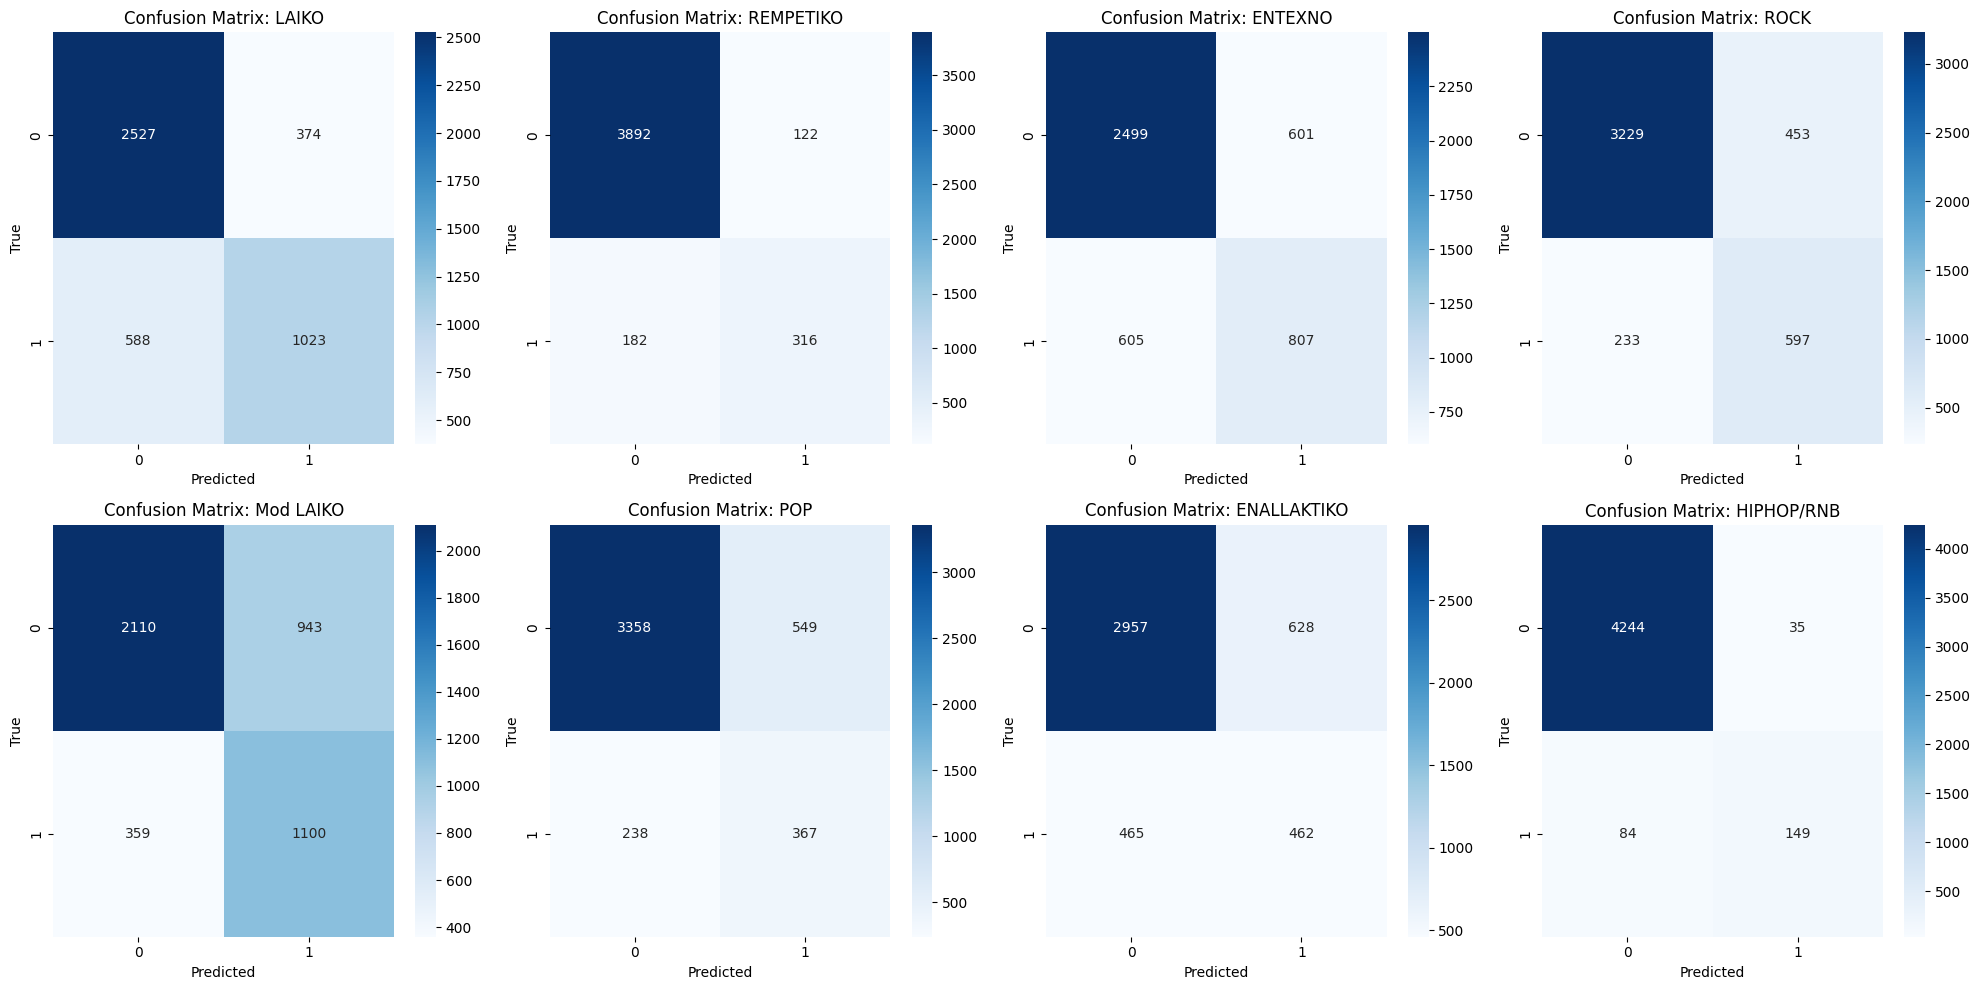

In [45]:
# Visualize results
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot confusion matrix for each genre
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
cms = []

for i, (genre, ax) in enumerate(zip(genre_names, axes)):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    cms.append(cm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {genre}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    
plt.tight_layout()
plt.show();

In [46]:
for cm in cms:
    print(cm)

[[2527  374]
 [ 588 1023]]
[[3892  122]
 [ 182  316]]
[[2499  601]
 [ 605  807]]
[[3229  453]
 [ 233  597]]
[[2110  943]
 [ 359 1100]]
[[3358  549]
 [ 238  367]]
[[2957  628]
 [ 465  462]]
[[4244   35]
 [  84  149]]


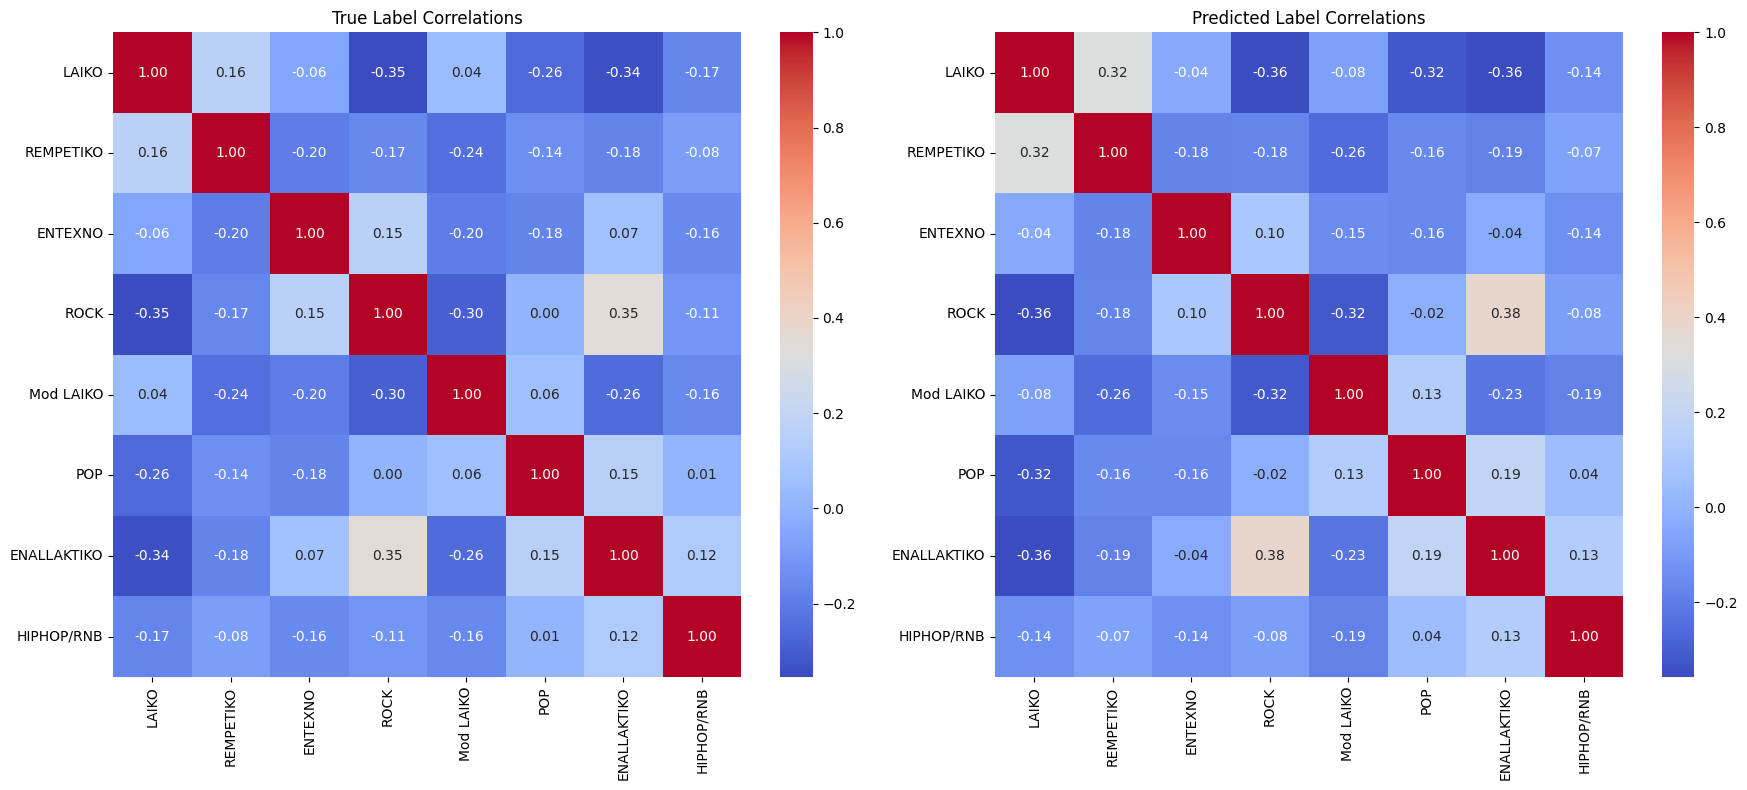

In [47]:
# correlation matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(true_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax1, 
            xticklabels=genre_names, yticklabels=genre_names)
ax1.set_title('True Label Correlations')

sns.heatmap(pred_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax2, 
            xticklabels=genre_names, yticklabels=genre_names)
ax2.set_title('Predicted Label Correlations')

plt.tight_layout()
plt.show();

In [48]:
# Create a new model that outputs only the dense embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("dense_output").output)

# Get the embeddings
dense_embeddings = embedding_model.predict(test_dataset, batch_size=64, steps=71)

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Run t-SNE (may take a minute)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_results = TSNE(n_components=2, perplexity=30).fit_transform(dense_embeddings)

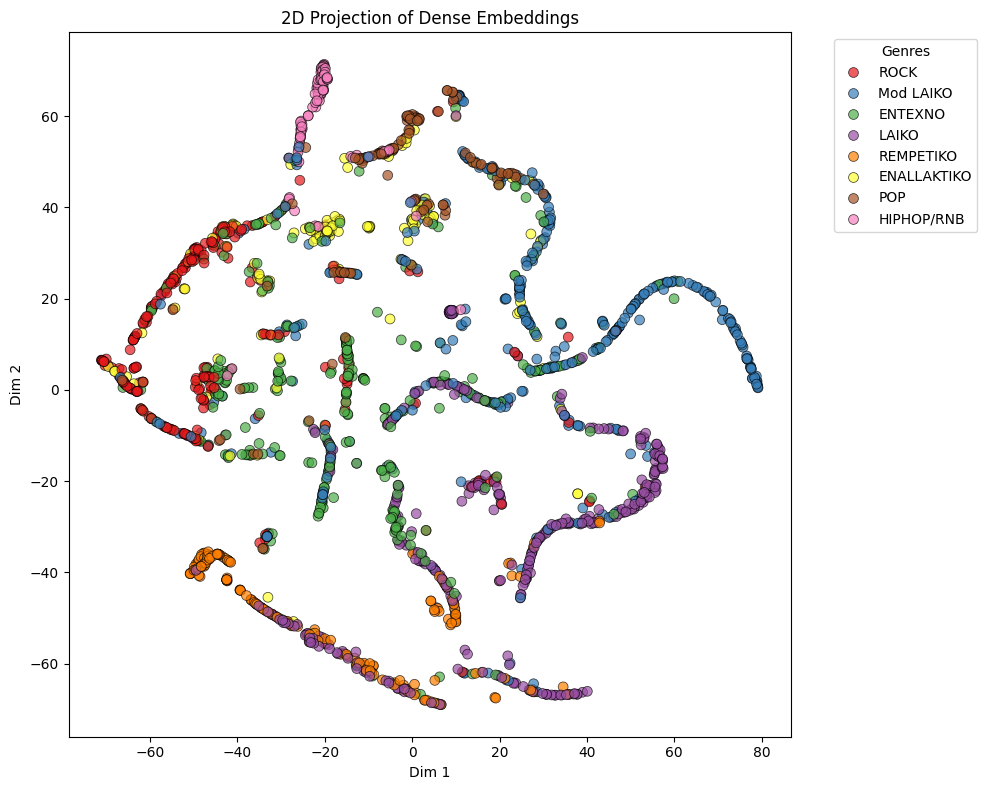

In [50]:
# Get most prominent label for coloring with argmax
single_label_mask = np.sum(y_true, axis=1) == 1
x_embedded_filtered = tsne_results[single_label_mask]
y_labels = np.argmax(y_true[single_label_mask], axis=1)

plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(np.unique(y_labels)))

genre_names = ['LAIKO', 'REMPETIKO', 'ENTEXNO', 'ROCK', 'Mod LAIKO', 'POP', 'ENALLAKTIKO', 'HIPHOP/RNB']
y_labels_named = [genre_names[i] for i in y_labels]

sns.scatterplot(
    x=x_embedded_filtered[:, 0],
    y=x_embedded_filtered[:, 1],
    hue=y_labels_named,
    palette="Set1",  # updated for better color contrast
    alpha=0.7,
    s=50,
    edgecolor='k'
)


plt.title("2D Projection of Dense Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()